In [1]:
import pandas as pd
import numpy as np
import krippendorff
import seaborn as sns
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas()

In [2]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)


color_palette = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Grade Analysis

In [3]:
def apply_group(id):
    if id in [1, 2, 3, 4]:
        return '1-4'
    elif id in [5, 6, 7, 8]:
        return '5-8'
    elif id in [9, 10, 11, 12]:
        return '9-12'
    elif id in [13, 14, 15, 16]:
        return '13-16'
    elif id in [17, 18, 19, 20]:
        return '17-20'
    elif id in [21, 22, 23, 24]:
        return '21-24'
    else:
        return '25-28'

In [4]:
grade_df = pd.read_csv('Menagerie/data/grades.csv', index_col=0)
grade_df = grade_df[~grade_df['grade'].isnull()]
grade_df['grade'] = pd.Categorical(grade_df['grade'],
                                         ['A++', 'A+', 'A', 'A-',
                                          'B+', 'B', 'B-',
                                          'C+', 'C', 'C-',
                                          'D+', 'D', 'D-',
                                          'F', 'NAN'])

grade_df['primary_grade'] = grade_df['grade'].apply(lambda x: x[0])
grade_df['primary_grade'] = pd.Categorical(grade_df['primary_grade'], ['A', 'B', 'C', 'D', 'F'])

grade_df['group'] = grade_df['participant_id'].apply(apply_group)
grade_df['group'] = pd.Categorical(grade_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])


# Removed as this was accidentally duplicated
grade_df = grade_df[grade_df['assignment_number'] != 105]
grade_df

,assignment_number,comments,skill,participant_id,batch,grade,primary_grade,group
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,B,13-16
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,A,13-16
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,A,13-16
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A,13-16
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A,13-16
...,...,...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++,A,13-16
16,353.0,NaN,Documentation,14,1,A++,A,13-16
17,422.0,NaN,Documentation,14,1,A++,A,13-16
18,480.0,NaN,Documentation,14,1,A++,A,13-16


# Inter-Rater Analysis

In [5]:
def calculate_all_reliability_metric(metric, grade_col='grade', one_away=False):
    results_df = None
    
    for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
        for group in grade_df['group'].unique():
            try:
                
                if metric.lower() == 'fleiss':
                    metric_result = calculate_fleiss_kappa(skill, group, grade_col)
                else:
                    metric_result = calculate_krippendorrf_alpha(skill, group, grade_col, one_away)
                
                results_df = pd.concat([results_df, pd.DataFrame({
                                        'group': group,
                                        'skill': skill,
                                        'metric_result': metric_result}, index=[0])])

                results_df['group'] = pd.Categorical(results_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
            except ValueError as e:
                print('Error duplicate entries check data for: ', group)
                raise e
    
    return results_df

In [6]:
def plot_heatmap(df, file_name):
    pivot_df = df.pivot(index='group', columns='skill', values='metric_result')
    g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
    g.get_figure().savefig(f'plots/{file_name}.pdf', bbox_inches='tight')

### Fleiss Kappa

In [7]:
def calculate_fleiss_kappa(skill, group, grade_col):
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', 'group', grade_col]]
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')
    pivot = group_df.pivot(index='assignment_number', columns='participant_id', values=grade_col)
    if any(pivot.isna().any(axis=1)):
        print('Missing Grade: ', pivot[pivot.isna().any(axis=1)])
        pivot.dropna(inplace=True)

    return fleiss_kappa(aggregate_raters(pivot)[0], 'fleiss')

### Fine-Grained

In [8]:
fine_df = calculate_all_reliability_metric('fleiss').sort_values(by='group')
fine_df

Missing Grade:  participant_id      13  14  15 16
assignment_number                
306.0              NaN  A+  B+  A
Missing Grade:  participant_id      21   22   23  24
assignment_number                   
10.0               NaN   A+   D+   F
410.0              NaN   C+   A+  A-
654.0              NaN  A++  A++  D-
Missing Grade:  participant_id      25   26   27   28
assignment_number                    
394.0              A++  A++  NaN  A++
Missing Grade:  participant_id      9  10  11  12
assignment_number                
117.0              NaN  B  A+  A-


,group,skill,metric_result
0,1-4,Documentation,0.001796
0,1-4,Correctness,0.042673
0,1-4,Code Elegance,-0.003257
0,1-4,Readability,-0.002874
0,5-8,Documentation,-0.071363
0,5-8,Correctness,-0.024104
0,5-8,Code Elegance,-0.013182
0,5-8,Readability,-0.070433
0,9-12,Readability,-0.069315
0,9-12,Code Elegance,-0.026386


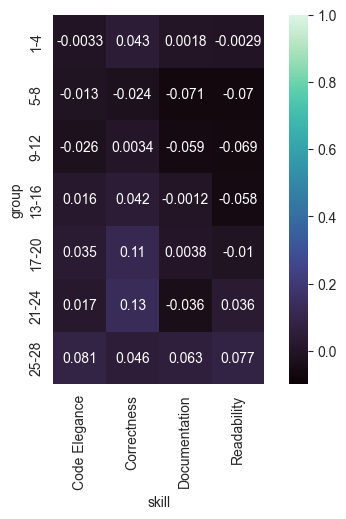

In [9]:
plot_heatmap(fine_df, 'fliess_kappa_fine')

## Less granular analysis

In [10]:
coarse_df = calculate_all_reliability_metric('fleiss', 'primary_grade').sort_values(by='group')
coarse_df

Missing Grade:  participant_id      13 14 15 16
assignment_number              
306.0              NaN  A  B  A
Missing Grade:  participant_id      21 22 23 24
assignment_number              
10.0               NaN  A  D  F
410.0              NaN  C  A  A
654.0              NaN  A  A  D
Missing Grade:  participant_id      21 22 23 24
assignment_number              
10.0               NaN  A  B  A
51.0               NaN  F  F  A
77.0               NaN  B  B  A
124.0              NaN  A  B  A
160.0              NaN  A  B  B
252.0              NaN  A  A  A
292.0              NaN  A  A  A
311.0              NaN  B  A  C
410.0              NaN  B  A  A
473.0              NaN  A  B  A
490.0              NaN  A  A  B
523.0              NaN  A  A  A
549.0              NaN  A  B  A
624.0              NaN  A  A  B
654.0              NaN  A  A  B
Missing Grade:  participant_id    25 26   27 28
assignment_number              
394.0              A  A  NaN  A
Missing Grade:  participant_id      9  1

,group,skill,metric_result
0,1-4,Documentation,0.153560
0,1-4,Correctness,0.245128
0,1-4,Code Elegance,0.110633
0,1-4,Readability,0.141092
0,5-8,Documentation,-0.085587
0,5-8,Correctness,-0.016199
0,5-8,Code Elegance,-0.072377
0,5-8,Readability,-0.061360
0,9-12,Readability,-0.010668
0,9-12,Code Elegance,-0.038231


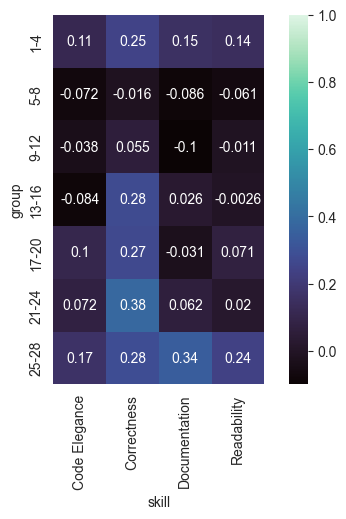

In [11]:
plot_heatmap(coarse_df, 'fliess_kappa_coarse')

#### Average Fliess Kappa
##### Skill

In [12]:
fine_df[['skill', 'metric_result']].groupby('skill').mean().reset_index()

,skill,metric_result
0,Code Elegance,0.015278
1,Correctness,0.050278
2,Documentation,-0.014126
3,Readability,-0.013877


In [13]:
coarse_df[['skill', 'metric_result']].groupby('skill').mean().reset_index()

,skill,metric_result
0,Code Elegance,0.036890
1,Correctness,0.212833
2,Documentation,0.052105
3,Readability,0.056083


##### Group

In [14]:
fine_df[['group', 'metric_result']].groupby('group').mean().reset_index()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_28839/3844126525.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_df[['group', 'metric_result']].groupby('group').mean().reset_index()


,group,metric_result
0,1-4,0.009584
1,5-8,-0.044771
2,9-12,-0.037831
3,13-16,-0.000166
4,17-20,0.035506
5,21-24,0.036410
6,25-28,0.066987


In [15]:
coarse_df[['group', 'metric_result']].groupby('group').mean().reset_index()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_28839/1297392622.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coarse_df[['group', 'metric_result']].groupby('group').mean().reset_index()


,group,metric_result
0,1-4,0.162603
1,5-8,-0.058881
2,9-12,-0.023879
3,13-16,0.053868
4,17-20,0.102609
5,21-24,0.133292
6,25-28,0.256731


### Krippendorrf's Alpha

In [16]:
def merge_grades(row):
    if row[row.index[0]] >= row[row.index[1]]:
        return str(row[row.index[0]]) + str(row[row.index[1]])
    else:
        return str(row[row.index[1]]) + str(row[row.index[0]])

In [17]:
GRADE_DICT = {i:v for i, v in enumerate(grade_df['grade'].sort_values().unique())}
ONE_AWAY_GRADES = [g+g for g in grade_df['grade'].sort_values().unique()] + [GRADE_DICT[i] + GRADE_DICT[i + 1] for i in range(len(GRADE_DICT.keys()) - 1)]
ONE_AWAY_GRADES

['A++A++',
 'A+A+',
 'AA',
 'A-A-',
 'B+B+',
 'BB',
 'B-B-',
 'C+C+',
 'CC',
 'C-C-',
 'D+D+',
 'DD',
 'D-D-',
 'FF',
 'NANNAN',
 'A++A+',
 'A+A',
 'AA-',
 'A-B+',
 'B+B',
 'BB-',
 'B-C+',
 'C+C',
 'CC-',
 'C-D+',
 'D+D',
 'DD-',
 'D-F',
 'FNAN']

In [107]:
# Grades are ordinal data or just stick with nominal? Are pairs of grades still ordinal?
def calculate_krippendorrf_alpha(skill, group, grade_col, one_away=False):
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', 'group', grade_col]].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    # Combinations adapted from: https://stackoverflow.com/questions/43347939/all-possible-combinations-of-columns-in-dataframe-pandas-python
    if one_away:
        one_away_pivot = group_df.pivot(index='assignment_number', columns='participant_id', values=grade_col)   
        one_away_pivot = one_away_pivot.fillna('NAN')
        
        participant_combinations = list(combinations(one_away_pivot.columns, 2))
        one_away_grade_df = pd.concat([one_away_pivot[[c[0], c[1]]].apply(lambda row: merge_grades(row), axis=1) for c in participant_combinations], axis=1, keys=participant_combinations)
        one_away_grade_df.columns = [f'{c[0]}-{c[1]}' for c in participant_combinations]
                
        for col in one_away_grade_df.columns:
            one_away_grade_df[col] = one_away_grade_df[col].apply(lambda g: np.nan if not g in ONE_AWAY_GRADES else g)
            one_away_grade_df[col] = pd.Categorical(one_away_grade_df[col], ONE_AWAY_GRADES)
            # one_away_grade_df[col] = pd.Categorical(one_away_grade_df[col])
            one_away_grade_df[col] = one_away_grade_df[col].cat.codes
            one_away_grade_df[col] = one_away_grade_df[col].apply(lambda c: np.nan if c == -1 else c)

        one_away_grade_df = one_away_grade_df.transpose()
        # return one_away_grade_df
        
        return krippendorff.alpha(one_away_grade_df.to_numpy(), level_of_measurement='ordinal')

    group_df[grade_col] = group_df[grade_col].cat.codes
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values=grade_col)
        

    return krippendorff.alpha(pivot.to_numpy(), level_of_measurement='ordinal')

In [108]:
calculate_krippendorrf_alpha('Correctness', '13-16', 'grade', True)

0.19569118781030537

#### Fine-Grained

In [109]:
fine_alpha_df = calculate_all_reliability_metric('krippendorff', 'grade').sort_values(by='group')
fine_alpha_df

,group,skill,metric_result
0,1-4,Documentation,0.102318
0,1-4,Correctness,0.281601
0,1-4,Code Elegance,0.071930
0,1-4,Readability,0.034320
0,5-8,Documentation,-0.101600
0,5-8,Correctness,-0.069250
0,5-8,Code Elegance,0.042380
0,5-8,Readability,-0.110749
0,9-12,Readability,0.097416
0,9-12,Code Elegance,0.066531


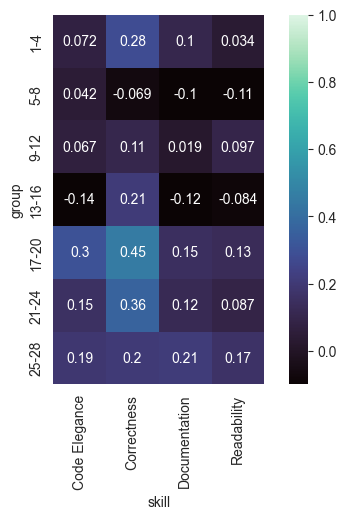

In [110]:
plot_heatmap(fine_alpha_df, 'krippendorrf_fine')

In [111]:
fine_alpha_df[['skill', 'metric_result']].groupby('skill').mean().reset_index()

,skill,metric_result
0,Code Elegance,0.098628
1,Correctness,0.220210
2,Documentation,0.054779
3,Readability,0.045598


#### Coarse-Grained

In [112]:
coarse_alpha_df = calculate_all_reliability_metric('krippendorff', 'primary_grade').sort_values(by='group')
coarse_alpha_df

,group,skill,metric_result
0,1-4,Documentation,0.259578
0,1-4,Correctness,0.374979
0,1-4,Code Elegance,0.173165
0,1-4,Readability,0.235572
0,5-8,Documentation,-0.089358
0,5-8,Correctness,-0.044634
0,5-8,Code Elegance,-0.000533
0,5-8,Readability,-0.067047
0,9-12,Readability,0.086742
0,9-12,Code Elegance,0.041857


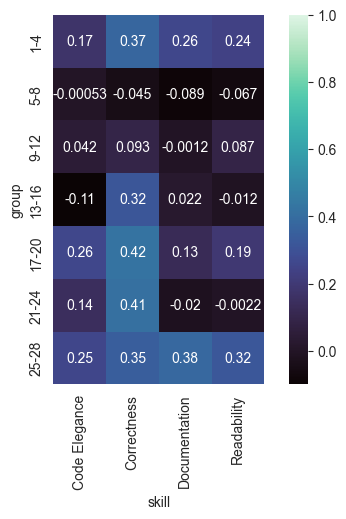

In [113]:
plot_heatmap(coarse_alpha_df, 'krippendorrf_coarse')

In [114]:
coarse_alpha_df[['skill', 'metric_result']].groupby('skill').mean().reset_index()

,skill,metric_result
0,Code Elegance,0.108499
1,Correctness,0.273630
2,Documentation,0.096660
3,Readability,0.107580


#### One Away

In [95]:
one_away_alpha_df = calculate_all_reliability_metric('krippendorff', 'grade', True).sort_values(by='group')
one_away_alpha_df

,group,skill,metric_result
0,1-4,Documentation,0.404511
0,1-4,Correctness,0.472395
0,1-4,Code Elegance,0.414365
0,1-4,Readability,0.362884
0,5-8,Documentation,0.294919
0,5-8,Correctness,0.317218
0,5-8,Code Elegance,0.421584
0,5-8,Readability,0.214193
0,9-12,Readability,0.451626
0,9-12,Code Elegance,0.270859


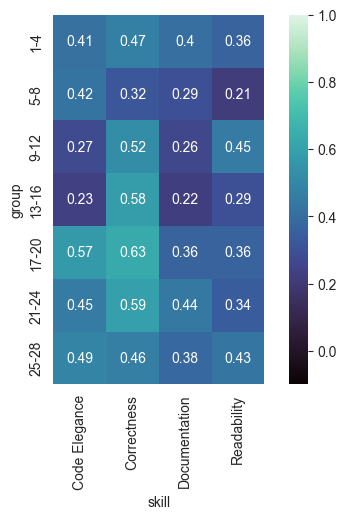

In [96]:
plot_heatmap(one_away_alpha_df, 'krippendorrf_one_away')

In [97]:
one_away_alpha_df[['skill', 'metric_result']].groupby('skill').mean().reset_index()

,skill,metric_result
0,Code Elegance,0.408169
1,Correctness,0.511259
2,Documentation,0.338765
3,Readability,0.350793


## Distance between grades

In [32]:
def get_grade(df, grade_col, group, skill, assignment_number, participant_id):
    grade = df[(df['group'] == group) &
                         (df['skill'] == skill) &
                         (df['assignment_number'] == assignment_number) &
                         (df['participant_id'] == participant_id)][grade_col]

    if grade.empty:
        return None
    return grade

In [33]:
def generate_grade_pairs(df, grade_col, group, skill, assignment_number):
    group_bounds = group.split('-')
    pairs = combinations(range(int(group_bounds[0]), int(group_bounds[1]) + 1), r=2)
    
    grade_pairs_df = None
    
    
    for idx, pair in enumerate(pairs):
        grade_1 = get_grade(df, grade_col, group, skill, assignment_number, pair[0])
        grade_2 = get_grade(df, grade_col, group, skill,assignment_number, pair[1])
    
        if grade_pairs_df is None:
            grade_pairs_df = pd.DataFrame({'group': group,
                                              'skill': skill,
                                              'assignment_number': assignment_number,
                                              'participant_id_1': pair[0],
                                              'participant_id_2': pair[1],
                                              'grade_1': grade_1,
                                              'grade_2': grade_2
                                              }, index=[idx])
        else:
            grade_pairs_df = pd.concat([
                grade_pairs_df,
                pd.DataFrame({'group': group, 'assignment_number': assignment_number, 'skill': skill,
                              'participant_id_1': pair[0],
                              'participant_id_2': pair[1],
                              'grade_1': grade_1,
                              'grade_2': grade_2
                              }, index=[idx])]
            )


    grade_pairs_df['group'] = pd.Categorical(grade_pairs_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
    return grade_pairs_df
        

In [34]:
def get_distance_df(df, grade_col):
    dist_df = None
    
    for group in tqdm(df['group'].unique()):
        for skill in df['skill'].unique():
            for n in df[(df['group'] == group) &
                               (df['skill'] == skill)]['assignment_number'].unique():
                if  dist_df is None:
                    dist_df = generate_grade_pairs(df, grade_col, group, skill, n)
                else:
                    dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
    
    dist_df = dist_df.dropna()
    dist_df['grade_1_code'] = dist_df['grade_1'].cat.codes
    dist_df['grade_2_code'] = dist_df['grade_2'].cat.codes
    dist_df['distance'] = abs(dist_df['grade_1_code'] - dist_df['grade_2_code'])
    
    return dist_df
            

#### Boxplot

##### Fine

  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_28839/3626878353.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
 14%|█▍        | 1/7 [00:01<00:09,  1.51s/it]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_28839/195055873.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grade_pairs_df = pd.concat([
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/

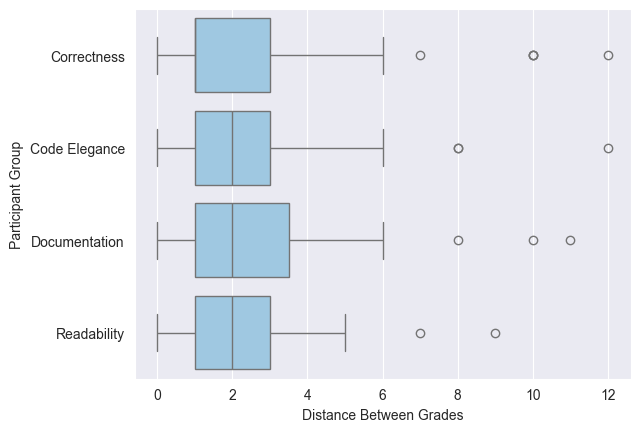

In [35]:
fine_dist_df = get_distance_df(grade_df, 'grade').sort_values(by='group')
g = sns.boxplot(fine_dist_df, y='skill', x='distance', color=blue)
g.set(xlabel='Distance Between Grades', ylabel='Participant Group')
g.get_figure().savefig('plots/fine_grade_distance.pdf', bbox_inches='tight')

In [36]:
fine_dist_df.groupby('skill')['distance'].mean()

skill
Code Elegance    2.385542
Correctness      2.313253
Documentation    2.433735
Readability      1.927711
Name: distance, dtype: float64

##### Coarse

  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_28839/3626878353.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
 14%|█▍        | 1/7 [00:01<00:07,  1.29s/it]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_28839/195055873.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grade_pairs_df = pd.concat([
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/

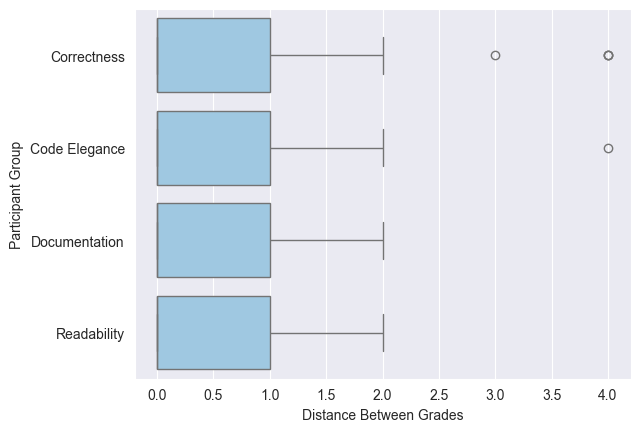

In [37]:
coarse_dist_df = get_distance_df(grade_df, 'primary_grade').sort_values(by='group')
g = sns.boxplot(coarse_dist_df, y='skill', x='distance', color=blue)
g.set(xlabel='Distance Between Grades', ylabel='Participant Group')
g.get_figure().savefig('plots/coarse_grade_distance.pdf', bbox_inches='tight')

In [38]:
coarse_dist_df.groupby('skill')['distance'].mean()

skill
Code Elegance    0.590361
Correctness      0.602410
Documentation    0.487500
Readability      0.373494
Name: distance, dtype: float64

# Intra-Rater Relability

In [39]:
DUPLICATE_MAP = {
    680: 144,
    681: 559,
    682: 97,
    683: 358,
    684: 389,
    685: 160,
    686: 176
}

In [40]:
intra_rater_df = grade_df[grade_df['assignment_number'].isin(list(DUPLICATE_MAP.keys())+list(DUPLICATE_MAP.values()))][['assignment_number', 'skill', 'participant_id', 'batch', 'grade']]
intra_rater_df = intra_rater_df.sort_values('grade')
intra_rater_df

,assignment_number,skill,participant_id,batch,grade
7,680.0,Correctness,3,2,A++
13,685.0,Readability,22,2,A++
9,686.0,Code Elegance,25,2,A++
7,680.0,Readability,3,2,A++
16,684.0,Code Elegance,18,2,A++
...,...,...,...,...,...
14,682.0,Documentation,10,2,F
7,97.0,Code Elegance,10,1,F
7,97.0,Correctness,10,1,F
7,97.0,Readability,10,1,F


### Map replacement IDs to original IDs

In [41]:
intra_rater_df['assignment_number'] = intra_rater_df['assignment_number'].apply(lambda x: x if x not in DUPLICATE_MAP.keys() else DUPLICATE_MAP[x])
intra_rater_df['grade_code'] = intra_rater_df['grade'].cat.codes
intra_rater_df

,assignment_number,skill,participant_id,batch,grade,grade_code
7,144.0,Correctness,3,2,A++,0
13,160.0,Readability,22,2,A++,0
9,176.0,Code Elegance,25,2,A++,0
7,144.0,Readability,3,2,A++,0
16,389.0,Code Elegance,18,2,A++,0
...,...,...,...,...,...,...
14,97.0,Documentation,10,2,F,13
7,97.0,Code Elegance,10,1,F,13
7,97.0,Correctness,10,1,F,13
7,97.0,Readability,10,1,F,13


In [42]:
pivot = intra_rater_df.pivot(index=['assignment_number', 'skill', 'participant_id'], columns='batch', values='grade').reset_index()
pivot.columns = ['assignment_number', 'skill', 'participant_id', 'grade_1', 'grade_2']
pivot

,assignment_number,skill,participant_id,grade_1,grade_2
0,97.0,Code Elegance,9,A-,B+
1,97.0,Code Elegance,10,F,F
2,97.0,Code Elegance,11,A-,A+
3,97.0,Code Elegance,12,A-,B
4,97.0,Correctness,9,B+,A
...,...,...,...,...,...
107,559.0,Documentation,8,A,A
108,559.0,Readability,5,A-,B+
109,559.0,Readability,6,A-,A++
110,559.0,Readability,7,A+,A+


## Distance between grade notches

In [43]:
pivot['grade_1_code'] = pivot['grade_1'].cat.codes
pivot['grade_2_code'] = pivot['grade_2'].cat.codes
pivot['distance'] = pivot['grade_1_code'] - pivot['grade_2_code']
pivot

,assignment_number,skill,participant_id,grade_1,grade_2,grade_1_code,grade_2_code,distance
0,97.0,Code Elegance,9,A-,B+,3,4,-1
1,97.0,Code Elegance,10,F,F,13,13,0
2,97.0,Code Elegance,11,A-,A+,3,1,2
3,97.0,Code Elegance,12,A-,B,3,5,-2
4,97.0,Correctness,9,B+,A,4,2,2
...,...,...,...,...,...,...,...,...
107,559.0,Documentation,8,A,A,2,2,0
108,559.0,Readability,5,A-,B+,3,4,-1
109,559.0,Readability,6,A-,A++,3,0,3
110,559.0,Readability,7,A+,A+,1,1,0


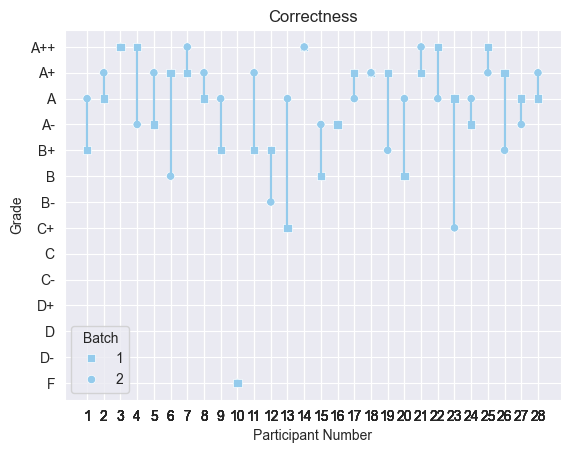

In [44]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Correctness'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Correctness'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)
    
dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Correctness', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/correctness_distance.pdf', bbox_inches='tight')

In [45]:
pivot[pivot['skill'] == 'Correctness']['distance'].abs().mean()

1.7857142857142858

In [46]:
pivot[(pivot['skill'] == 'Correctness') & (pivot['distance'] == 0)]['participant_id']

5     10
22     3
69    14
71    16
85    18
Name: participant_id, dtype: int64

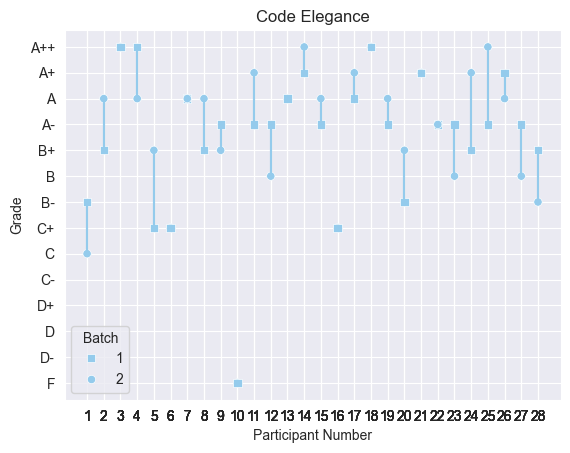

In [47]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Code Elegance', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/code_elegance_distance.pdf', bbox_inches='tight')

In [48]:
pivot[pivot['skill'] == 'Code Elegance']['distance'].abs().mean()

1.25

In [49]:
pivot[(pivot['skill'] == 'Code Elegance') & (pivot['distance'] == 0)]['participant_id']

1     10
18     3
32    21
33    22
64    13
67    16
81    18
97     6
98     7
Name: participant_id, dtype: int64

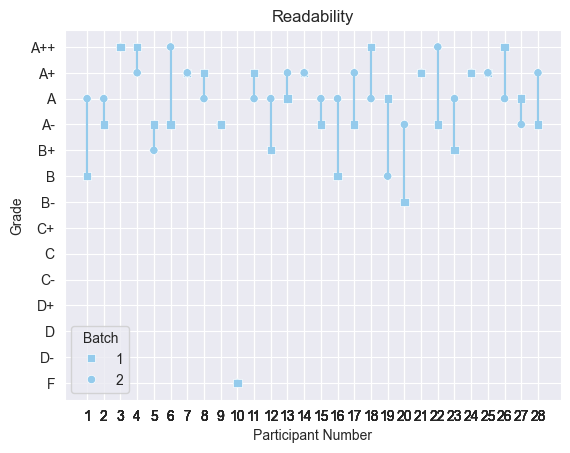

In [50]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Readability'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Readability'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Readability', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/readability_distance.pdf', bbox_inches='tight')

In [51]:
pivot[pivot['skill'] == 'Readability']['distance'].abs().mean()

1.3571428571428572

In [52]:
pivot[(pivot['skill'] == 'Readability') & (pivot['distance'] == 0)]['participant_id']

12      9
13     10
30      3
44     21
47     24
60     25
77     14
110     7
Name: participant_id, dtype: int64

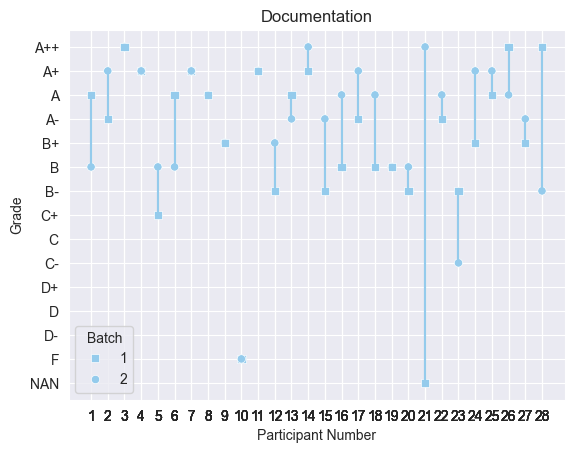

In [53]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Documentation'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Documentation'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Documentation', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/documentation_distance.pdf', bbox_inches='tight')

In [54]:
pivot[pivot['skill'] == 'Documentation']['distance'].abs().mean()

2.0357142857142856

In [55]:
pivot[(pivot['skill'] == 'Documentation') & (pivot['distance'] == 0)]['participant_id']

8       9
9      10
10     11
26      3
27      4
90     19
106     7
107     8
Name: participant_id, dtype: int64

# Summary of Grades per skill

In [56]:
grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})
grade_count_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_28839/1988006025.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})


,skill,grade,count
0,Code Elegance,A++,148
1,Code Elegance,A+,197
2,Code Elegance,A,189
3,Code Elegance,A-,132
4,Code Elegance,B+,116
5,Code Elegance,B,127
6,Code Elegance,B-,73
7,Code Elegance,C+,53
8,Code Elegance,C,21
9,Code Elegance,C-,13


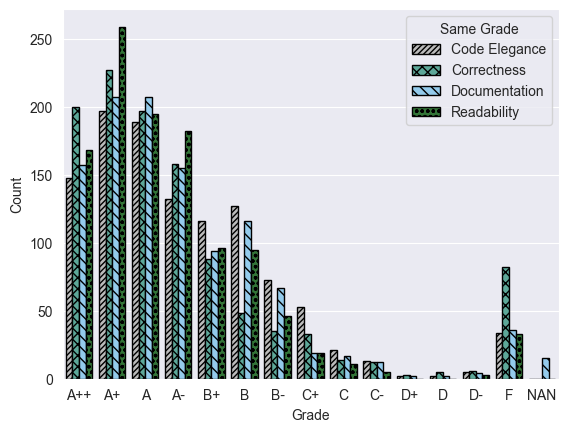

In [57]:
grade_plt = sns.barplot(x='grade', y='count', data=grade_count_df, hue='skill')

hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, grade_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

grade_plt.set(xlabel='Grade', ylabel='Count')
handles = grade_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')


grade_plt.legend(title='Same Grade')
grade_plt.get_figure().savefig('plots/grade_count.pdf', bbox_inches='tight')

In [58]:
lower_b = grade_count_df[~grade_count_df['grade'].isin(['A++', 'A+', 'A', 'A-', 'B+', 'B', 'B-'])]['count'].sum()

(lower_b / grade_count_df['count'].sum()) * 100

10.423232778027916